[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neverorfrog/whistlenet/blob/main/whistlenet/scripts/main_whistle_colab.ipynb)

In [1]:
import sys

COLAB_RUNTIME = 'google.colab' in sys.modules
if COLAB_RUNTIME:
    !git init
    !git remote add origin https://github.com/neverorfrog/whistlenet.git
    !git pull origin main
    !pip install -q -r requirements.txt
else:
    !pip install -q -r requirements.txt
    !pre-commit autoupdate
    !pre-commit install

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
[https://github.com/psf/black] already up to date!
[https://github.com/pycqa/isort] already up to date!
pre-commit installed at .git/hooks/pre-commit


In [2]:
from config import *
import os
import warnings
warnings.filterwarnings("ignore")
import torch
import numpy as np
from whistlenet.core.utils import project_root

config_path = os.path.join(project_root(), "config","whistle_config.yaml")
config: Config = load_config(config_path)
torch_config: TorchConfig = config.torch
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
whistlenet_config: WhistlenetConfig = config.whistlenet
torch.manual_seed(torch_config.seed)
np.random.seed(torch_config.seed)

Retrieving folder contents


Processing file 1dc2FqNsN1BeupwI69jOBO2Mu4eDdQ7IH test_data.dat
Processing file 1zjryxMe7YjkmYP_Jdw3vt-iew9Koh2Fi train_data.dat
Processing file 1ISkdz-ZGg9TfPAqAqD18rhi8IaEHdfuO val_data.dat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1dc2FqNsN1BeupwI69jOBO2Mu4eDdQ7IH
From (redirected): https://drive.google.com/uc?id=1dc2FqNsN1BeupwI69jOBO2Mu4eDdQ7IH&confirm=t&uuid=320bde68-f158-49a3-b888-be02672d577d
To: /home/neverorfrog/code/whistle/whistlenet/whistlenet/scripts/data/whistle/saved/overunder/test_data.dat
100%|██████████| 119M/119M [00:02<00:00, 42.4MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1zjryxMe7YjkmYP_Jdw3vt-iew9Koh2Fi
From (redirected): https://drive.google.com/uc?id=1zjryxMe7YjkmYP_Jdw3vt-iew9Koh2Fi&confirm=t&uuid=ab821a4f-0ac6-42ce-8c59-9899b024f329
To: /home/neverorfrog/code/whistle/whistlenet/whistlenet/scripts/data/whistle/saved/overunder/train_data.dat
100%|██████████| 564M/564M [00:11<00:00, 51.0MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1ISkdz-ZGg9TfPAqAqD18rhi8IaEHdfuO
To: /home/neverorfrog/

DATA LOADED!

N Examples: 219862
N Classes: 2
Classes: [0. 1.]
 - Class 0: 109938 (50.00318381530232)
 - Class 1: 109924 (49.99681618469767)


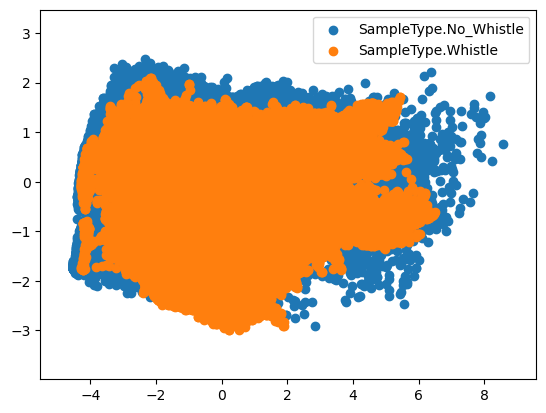

In [3]:
from whistlenet.data import WhistleDataset
from whistlenet.core.utils import plot, NUM_FREQS
from whistlenet.core.utils.audio import SampleType
import gdown

download_path = os.path.join(dataset_config.download_folder, dataset_config.name)
gdown.download_folder(
   dataset_config.drive_url, output=download_path
)

dataset = WhistleDataset(dataset_config)
dataset.summarize()
reshaped = dataset.train_data.reshape((dataset.train_data.data.shape[0], NUM_FREQS))
plot(reshaped, dataset.train_data.labels, SampleType)

In [4]:
from whistlenet.models import WhistleNet, Baseline
from whistlenet.core import LightningTrainer

# model = WhistleNet(in_channels=1, out_channels=1, config=whistlenet_config)
model = Baseline(config=baseline_config)
trainer = LightningTrainer(trainer_config)
trainer.fit(model,dataset)

wandb: Currently logged in as: neverorfrog (neverorfrog-sapienza). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/neverorfrog/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name            | Type            | Params | Mode 
-------------------------------------------------------------
0  | train_f1        | BinaryF1Score   | 0      | train
1  | train_precision | BinaryPrecision | 0      | train
2  | train_recall    | BinaryRecall    | 0      | train
3  | train_accuracy  | BinaryAccuracy  | 0      | train
4  | val_f1          | BinaryF1Score   | 0      | train
5  | val_precision   | BinaryPrecision | 0      | train
6  | val_recall      | BinaryRecall    | 0      | train
7  | val_accuracy    | BinaryAccuracy  | 0      | train
8  | test_f1         | BinaryF1Score   | 0      | train
9  | test_precision  | BinaryPrecision | 0      | train
10 | test_recall     | BinaryRecall    | 0      | train
11 | test_accuracy   | BinaryAccuracy  | 0      | train
12 | conv            | Sequential      | 93.1 K | train
13 | fc              | Sequential      | 1

Epoch 0:  12%|█▏        | 213/1718 [00:09<01:07, 22.18it/s, v_num=qlsc]    


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined